In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
#export
from exp.nb_06 import *

## ConvNet 

In [30]:
x_train, y_train, x_valid, y_valid = get_data()

x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [31]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [32]:
nfs = [8, 16, 32, 64]

In [33]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [42]:
%time run.fit(2, learn)

train: [1.34067890625, tensor(0.5748, device='cuda:0')]
valid: [0.281391064453125, tensor(0.9152, device='cuda:0')]
train: [0.2268558984375, tensor(0.9317, device='cuda:0')]
valid: [0.19683922119140626, tensor(0.9408, device='cuda:0')]
CPU times: user 3.36 s, sys: 586 ms, total: 3.94 s
Wall time: 3.57 s


## Batchnorm 

In [51]:
torch.randn(1,4,2,3).mean((0, 2, 3), keepdim=True)

tensor([[[[ 0.6770]],

         [[-0.4808]],

         [[-0.5149]],

         [[-0.0923]]]])

In [69]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer("vars", torch.ones(1,nf,1,1))
        self.register_buffer("means", torch.zeros(1,nf,1,1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m, v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [70]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [71]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [72]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.4201842578125, tensor(0.8796, device='cuda:0')]
valid: [0.208869677734375, tensor(0.9340, device='cuda:0')]


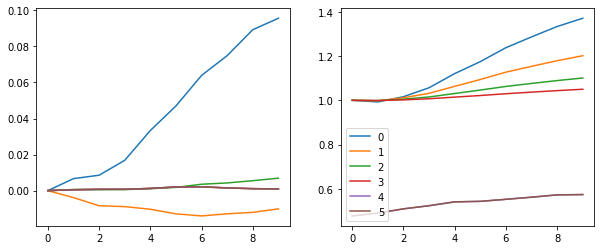

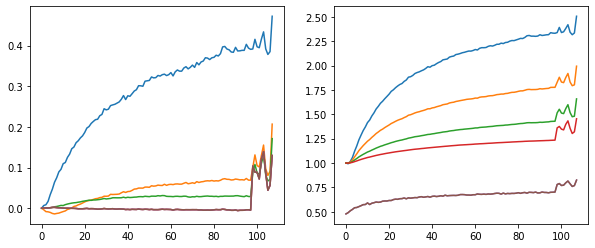

In [73]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [74]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [75]:
%time run.fit(3, learn)

train: [0.429316015625, tensor(0.8766, device='cuda:0')]
valid: [0.4212212890625, tensor(0.8770, device='cuda:0')]
train: [0.15963859375, tensor(0.9531, device='cuda:0')]
valid: [0.17403665771484375, tensor(0.9443, device='cuda:0')]
train: [0.117325732421875, tensor(0.9648, device='cuda:0')]
valid: [0.10306614990234375, tensor(0.9689, device='cuda:0')]
CPU times: user 2.76 s, sys: 345 ms, total: 3.1 s
Wall time: 2.51 s


In [79]:
learn.model[0], learn.model[0].children()

(Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
   (1): GeneralRelu()
   (2): BatchNorm()
 ), <generator object Module.children at 0x7f4fb180aad0>)

### Builtin batchnorm 

In [80]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [82]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [83]:
%time run.fit(3, learn)

train: [0.2926708203125, tensor(0.9168, device='cuda:0')]
valid: [0.094412060546875, tensor(0.9737, device='cuda:0')]
train: [0.0808111474609375, tensor(0.9761, device='cuda:0')]
valid: [0.0656488525390625, tensor(0.9800, device='cuda:0')]
train: [0.0546122509765625, tensor(0.9834, device='cuda:0')]
valid: [0.05529545288085937, tensor(0.9841, device='cuda:0')]
CPU times: user 2.69 s, sys: 301 ms, total: 2.99 s
Wall time: 2.4 s


### With scheduler 

In [84]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [86]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs +
                          [partial(ParamScheduler, 'lr', sched)])

In [87]:
run.fit(8, learn)

train: [0.3787280859375, tensor(0.8937, device='cuda:0')]
valid: [0.130718408203125, tensor(0.9599, device='cuda:0')]
train: [0.0915415234375, tensor(0.9720, device='cuda:0')]
valid: [0.07990220947265625, tensor(0.9765, device='cuda:0')]
train: [0.0649271630859375, tensor(0.9804, device='cuda:0')]
valid: [0.06806746826171875, tensor(0.9808, device='cuda:0')]
train: [0.042505908203125, tensor(0.9871, device='cuda:0')]
valid: [0.05881412963867187, tensor(0.9839, device='cuda:0')]
train: [0.02984005615234375, tensor(0.9915, device='cuda:0')]
valid: [0.04816355895996094, tensor(0.9859, device='cuda:0')]
train: [0.02106832275390625, tensor(0.9944, device='cuda:0')]
valid: [0.04747289428710937, tensor(0.9863, device='cuda:0')]
train: [0.01555998291015625, tensor(0.9962, device='cuda:0')]
valid: [0.043239047241210936, tensor(0.9877, device='cuda:0')]
train: [0.011617352294921874, tensor(0.9979, device='cuda:0')]
valid: [0.04245745239257812, tensor(0.9880, device='cuda:0')]


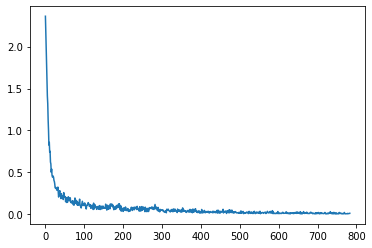

In [89]:
run.recorder.plot_loss()

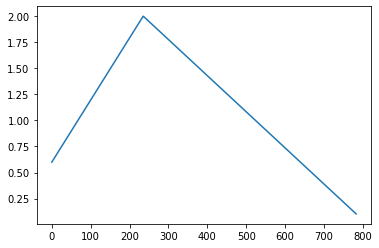

In [90]:
run.recorder.plot_lr()

In [94]:
its = x_train.shape[0]/512. * 8
its

781.25

In [97]:
0.3 * its, 0.7 * its # means for 3-% do linear increase, then remaining 70% do

(234.375, 546.875)

## More norms 

### Layer norm 

In [100]:
class LayerNorm(nn.Module):
    __constants__ = ["eps"]
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m)/((v+self.eps).sqrt())
        return x*self.mult + self.add

In [101]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [102]:
learn, run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [103]:
%time run.fit(3, learn)

train: [0.444791875, tensor(0.8573, device='cuda:0')]
valid: [0.13317918701171874, tensor(0.9577, device='cuda:0')]
train: [0.0982524609375, tensor(0.9698, device='cuda:0')]
valid: [0.08223027954101562, tensor(0.9740, device='cuda:0')]
train: [0.06433646484375, tensor(0.9800, device='cuda:0')]
valid: [0.08371817626953125, tensor(0.9735, device='cuda:0')]
CPU times: user 3.29 s, sys: 431 ms, total: 3.72 s
Wall time: 3.13 s


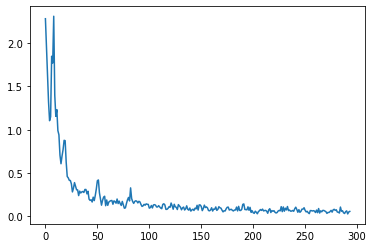

In [104]:
run.recorder.plot_loss()

In [ ]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds